### MNIST dataset for classification

#### 1. Frame the problem 

MNIST dataset consists of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represent. The goal is to build a classifier that can learn to distinguish the digits in the dataset. 

In [2]:
from sklearn.datasets import load_digits
mnist = load_digits() # it's pre-built in sklearn but only has 1797 images 
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape, y.shape)

(1797, 64) (1797,)


There are 1797 images and each image has 64 features (8x8 pixels), and each feature represents one pixel's intensity, from 0 (white) to 255 (black).

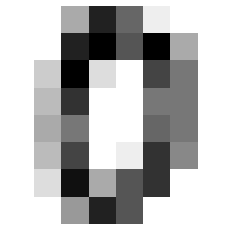

In [4]:
import matplotlib as mlp 
import matplotlib.pyplot as plt 

some_digit = X[0]
some_digit_image = some_digit.reshape(8, 8)
plt.imshow(some_digit_image, cmap = 'binary')
plt.axis("off")
plt.show()

In [5]:
y[0]

0

Labels are already integers so we don't need to cast them. 

#### 2. Split in training and test set

In [6]:
X_train, X_test, y_train, y_test = X[:1500], X[1500:], y[:1500], y[1500:] # Dataset has already been split

#### 3. Training a binary classifier

Let's simplify the problem and try to identify one digit only (number 5)

In [7]:
y_train_5 = (y_train == 5) # True for all 5s, false for all other digits 
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier 
sgd_clf = SGDClassifier(random_state = 1234)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=1234)

In [9]:
sgd_clf.predict([some_digit]) # Just checking that it does not predict the 0 as 5 

array([False])

#### 4. Performance measures

**Accuracy using cross validation** 

K-fold cross-validation means splitting the training set into K folds, then making predictions and evaluating them on each fold using a model trained on the remaining folds. 

In [10]:
from sklearn.model_selection import cross_val_score 
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.98 , 0.986, 0.986])

!! We get extrememly high accuracy (ratio of correct predictions) on all cross validation folds, but this is probably due to the fact that we have very few instances that are labeled as 5 in the dataset. To confirm if that is the case, we can make a dumb classifier that just classifies every image as "not 5" to check it's accuracy: 

In [11]:
from sklearn.base import BaseEstimator 
import numpy as np
class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        return self 
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [12]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.9  , 0.9  , 0.896])

As expected, by predicting always "not 5" we get 90% accuracy because there are about 10% instances of 5 in the dataset

**Confusion matrix**

To compute the confusion matrix, we need to have a set of predictions so that they can be compared to the actual targets. Each row in the confusion matrix represents an actual class, while each column represents a predicted class. 

 * first row (negative class) = considers non 5 images --> TRUE NEGATIVES, FALSE POSITIVES
 * second row (positive class) = considers images of 5 --> FALSE NEGATIVES, TRUE POSITIVES 

In [13]:
from sklearn.model_selection import cross_val_predict 
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [14]:
from sklearn.metrics import confusion_matrix 
confusion_matrix(y_train_5, y_train_pred)

array([[1339,    9],
       [  15,  137]])

In [15]:
y_train_perfect_prediction = y_train_5 
confusion_matrix(y_train_5, y_train_perfect_prediction)

array([[1348,    0],
       [   0,  152]])

A perfect classifier would have only true positives and true negatives (and 0 off diagonal terms)

**Important metrics that come from the confusion matrix**

#### PRECISION = True Positives / (True Positives + False Positives)

Accuracy of the positive predictions

#### RECALL = True Positives / (True Positives + False Negatives) 

Ratio of positive instances correctly detected by the classifier. Also called sensitivity or true positive rate.

In [16]:
from sklearn.metrics import precision_score, recall_score 
print("Precision: {}".format(precision_score(y_train_5, y_train_pred)))
print("Recall: {}".format(recall_score(y_train_5, y_train_pred)))

Precision: 0.9383561643835616
Recall: 0.9013157894736842


#### F1 SCORE = 2 * (precision * recall) / (precision + recall) 

F1 score is a harmonic mean of precision and recall --> favors classifiers that have similar precision and recall

In [19]:
from sklearn.metrics import f1_score
print("F1 score: {}".format(f1_score(y_train_5, y_train_pred)))

F1 score: 0.9194630872483222


#### Precision/Recall trade-off

Increasing precision reduces recall and viceversa. 
Working example: for each instance, SGDClassifier computes a score based on a decision function. If the score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class. With sklearn, we cannot set the threshold directly but we can access the decision scores used to make the prediction by calling the decision_function() method

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-1974.84813408])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Raising the threshold decreases recall!

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

In [25]:
from sklearn.metrics import precision_recall_curve 
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

<function matplotlib.pyplot.show(close=None, block=None)>

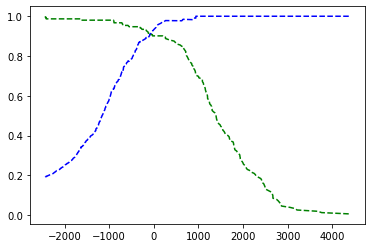

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label = "Recall")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show

To decide what threshold to use we can:
 * plot precision and recall versus the decision threshold
 * plot precision directly against recall
 * plot the **receiver operating characteristic (ROC) curve** : plots the true positive rate (recall) against false positive rate (1 - specificity)

In [28]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

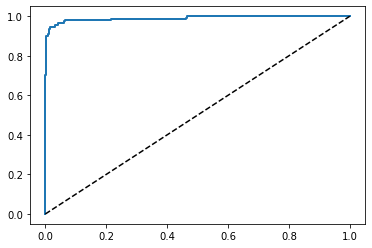

In [29]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], "k--")
    
plot_roc_curve(fpr, tpr)
plt.show()

Alternatively, from the ROC curve we can measure the area under the curve (AUC), which will be equal to 1 if the classifier has perfect performance or equal to 0.5 if it is purely random.

In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9900388489770422

**Note:**

As a rule of thumb, we should prefer the precision recall curve when the positive class is rare (as in this case) or when we care more about the false positive than the false negatives. Otherwise, use the ROC curve. 

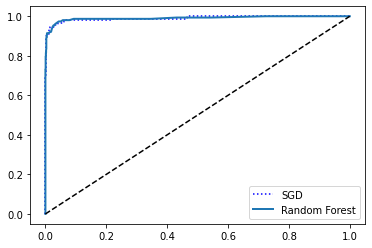

In [33]:
from sklearn.ensemble import RandomForestClassifier 
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, 
                                    method = "predict_proba")
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = 'lower right')
plt.show()

#### 5. Multiclass classification

Multiclass (or multinomial) classifiers can distinguish between more than two classes and can be adapted from binary classifiers in two ways: 
 
 1. **one-versus-rest strategy**: N classifiers total if there are N classes 
 2. **one-versus-one strategy**: N * (N -1) / 2 classifiers total if there are N classes, but each classifier needs to be trained only on the part of the training set that contains the two classes that it must distinguish 

In [34]:
from sklearn.svm import SVC 
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([0])

In [35]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 9.30959478, -0.29306863,  0.74803505,  4.80549668,  1.75678185,
         8.22976148,  3.808629  ,  2.75925812,  5.96703976,  7.25531897]])

In [36]:
np.argmax(some_digit_scores)

0

In [37]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

If we want to force sklearn to use one-versus-one or one-versus-rest, we can use the *OneVsOneClassifier* or the *OneVsRestClassifier* classes. 

In [38]:
from sklearn.multiclass import OneVsRestClassifier 
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [39]:
ovr_clf.predict([some_digit])

array([0])

In [41]:
len(ovr_clf.estimators_) # it has built 10 classifiers (number of classes)

10

In [42]:
# Same with SGDClassifier 
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([0])

In [43]:
sgd_clf.decision_function([some_digit])

array([[ 2905.03165742, -4528.68564663, -3129.53999747, -1338.93647228,
        -2066.42354718, -1673.88837471, -3807.15079461, -1955.16152804,
        -1166.17198619, -1044.95144976]])

In [44]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.892, 0.896, 0.934])

In [45]:
#Scale the inputs to increase accuracy 
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(float))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.896, 0.886, 0.956])

#### 6. Error Analysis

In [46]:
y_train_pred = cross_val_predict(svm_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[151,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 145,   1,   0,   1,   0,   2,   0,   2,   0],
       [  0,   1, 137,   1,   3,   0,   0,   1,   7,   0],
       [  0,   0,   2, 143,   2,   0,   0,   1,   4,   1],
       [  0,   0,   0,   0, 145,   0,   0,   2,   0,   1],
       [  0,   0,   0,   1,   0, 147,   1,   0,   1,   2],
       [  0,   1,   0,   0,   6,   0, 144,   0,   0,   0],
       [  0,   0,   0,   0,   5,   0,   0, 143,   0,   1],
       [  0,   7,   0,   0,   3,   1,   0,   0, 134,   1],
       [  0,   4,   0,   0,   3,   0,   0,   6,   3, 133]])

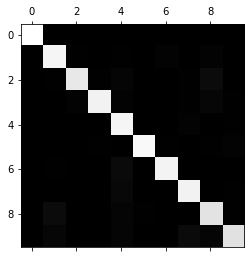

In [47]:
plt.matshow(conf_mx, cmap = plt.cm.gray)

To plot the errors:
 
 1. Divide each value in the confusion matrix by the number of images in the corresponding class so that we can compar error rates instead of number of errors.
 2. Fill in the diagonal with 0s to keep only the errors.

In [48]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

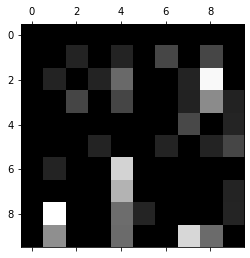

In [49]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)

!! Analyzing individual errors can be a good way of gaining insights on what the classifier is doing and why it is failing.

#### 7. Multilabel classification

If we want the classifier to output multiple classes for the same instance. Example: tell if a number in MNIST is both large and odd. 

In [50]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd] # multilabel array

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [51]:
knn_clf.predict([some_digit])

array([[False, False]])

To evaluate a multilabel classifier we can measure the F1 score for each individual label and then compute the average score.

In [52]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3 )
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

0.951371327508381

 * average = **macro** --> assumes all labels are equally important 

 * average = **weighted** --> gives each label a weight equal to its support (the number of instances with that target label)

#### 8. Multioutput classification

Generalization of multilabel classification where each label can be multiclass.
Example: build a classifier that removes noise from images. Takes a noise digit image and ouputs a clean digit image, represented as an array of pixel intensities (multilabel = one label per pixel, multiclass = pixel intensity ranges from 0 to 255).

In [53]:
noise = np.random.randint(0, 100, (len(X_train), 64))
X_train_mod = X_train + noise 
noise = np.random.randint(0, 100, (len(X_test), 64))
X_test_mod = X_test + noise 
y_train_mod = X_train 
y_test_mod = X_test

In [55]:
knn_clf.fit(X_train_mod, y_train_mod)
some_index = 3
clean_digit = knn_clf.predict([X_test_mod[some_index]])

#### End of notebook